# XLMR for crosslinual word in context sense disambiguation

## 1.1 XLMR
[XLM-RoBERTa](https://arxiv.org/abs/1911.02116) is a multilingual model trained on 100 different languages. It is based on RoBERTa: [A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692).

![](https://miro.medium.com/max/4800/1*2W7USnAt7tBVFb6IVqgzlA.png)

**XLMR vs BERT**
- Multilingual training dataset (100 languages)
- Multilingual tokenizer
- No "Next Sentence Prediction" loss
- Larger batch_size
- etc.

## 1.2 SemEval2021
**SemEval2021** task2: to distinguish whether the meanings of a target word in two provided contexts are the same or not.

- Click with a ***mouse*** on the shortcut

- A ***mouse*** ate the cheese

Also there are crosslingual sentece pairs.

## 1.3 All necessery imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install sentencepiece
# !pip install bitarray
# !pip install hydra-core

In [3]:
# !pip install sacrebleu

In [4]:
# !pip install tensorboardX
# !pip install soundfile
# !pip install editdistance

In [5]:
import json
import numpy as np
import torch
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from difflib import SequenceMatcher
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import pandas as pd
from tqdm.auto import tqdm

In [6]:
from transformers import XLMRobertaModel, XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlmr = XLMRobertaModel.from_pretrained('xlm-roberta-base')
xlmr.eval().cuda()
None

## 1.4 Downloading and preparing the datasets for Semeval 2021 competition

In [7]:
# !git clone https://github.com/SapienzaNLP/mcl-wic.git
# !unzip mcl-wic/SemEval-2021_MCL-WiC_all-datasets.zip
# !unzip mcl-wic/SemEval-2021_MCL-WiC_trial.zip
# !unzip mcl-wic/SemEval-2021_MCL-WiC_test-gold-data.zip

In [8]:
# English-English train (8k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/training/training.en-en.data", encoding="utf-8") as f:
    train_x = json.load(f)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/training/training.en-en.gold", encoding="utf-8") as f:
    train_y = json.load(f)

In [9]:
# English-English dev (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/dev/multilingual/dev.en-en.data", encoding="utf-8") as f:
    dev_enen_x = json.load(f)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/dev/multilingual/dev.en-en.gold", encoding="utf-8") as f:
    dev_enen_y = json.load(f)

In [10]:
# Russian-Russian test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/multilingual/test.ru-ru.data", encoding="utf-8") as f:
    test_ruru_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.ru-ru.gold", encoding="utf-8") as f:
    test_ruru_y = json.load(f)

In [11]:
# English-Russian test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets./MCL-WiC/test/crosslingual/test.en-ru.data", encoding="utf-8") as f:
    test_enru_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.en-ru.gold", encoding="utf-8") as f:
    test_enru_y = json.load(f)

In [12]:
# AR-AR test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/multilingual/test.ar-ar.data", encoding="utf-8") as f:
    test_arar_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.ar-ar.gold", encoding="utf-8") as f:
    test_arar_y = json.load(f)

In [13]:
# FR-FR test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/multilingual/test.fr-fr.data", encoding="utf-8") as f:
    test_frfr_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.fr-fr.gold", encoding="utf-8") as f:
    test_frfr_y = json.load(f)

In [14]:
# ZH-ZH test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/multilingual/test.zh-zh.data", encoding="utf-8") as f:
    test_zhzh_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.zh-zh.gold", encoding="utf-8") as f:
    test_zhzh_y = json.load(f)

In [15]:
# EN-FR test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/crosslingual/test.en-fr.data", encoding="utf-8") as f:
    test_enfr_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.en-fr.gold", encoding="utf-8") as f:
    test_enfr_y = json.load(f)

In [16]:
# EN-AR test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/crosslingual/test.en-ar.data", encoding="utf-8") as f:
    test_enar_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.en-ar.gold", encoding="utf-8") as f:
    test_enar_y = json.load(f)

In [17]:
# EN-ZH test (1k)
with open("SemEval-2021_MCL-WiC_all-datasets/MCL-WiC/test/crosslingual/test.en-zh.data", encoding="utf-8") as f:
    test_enzh_x = json.load(f)
with open("SemEval-2021_MCL-WiC_test-gold-data/test.en-zh.gold", encoding="utf-8") as f:
    test_enzh_y = json.load(f)

In [18]:
test_enru_x[0]

{'id': 'test.en-ru.0',
 'lemma': 'gently',
 'pos': 'ADV',
 'sentence1': "Unfortunately, that pressure seemed to have had some effect, and the Islamic Republic of Iran had been treated more gently in the 2008 Chairman's working paper.",
 'sentence2': 'На протяжении этого десятилетия цены на сырьевые товары в реальном выражении характеризовались в целом умеренной повышательной тенденцией.',
 'ranges1': '116-122',
 'ranges2': '103-112'}

In [19]:
test_enru_x[0]['sentence1'][116:122]

'gently'

In [20]:
test_enru_x[0]['sentence2'][103:1112]

'умеренной повышательной тенденцией.'

In [21]:
test_enru_y[0]

{'id': 'test.en-ru.0', 'tag': 'F'}

In [22]:
test_ruru_x[0]

{'id': 'test.ru-ru.0',
 'lemma': 'приглашение',
 'pos': 'NOUN',
 'sentence1': 'Автор утверждает, что не имеет средств для приглашения для этой цели адвоката и что в любом случае такая апелляция бесполезна.',
 'sentence2': 'Эта миссия была осуществлена по приглашению правительства Нигерии вследствие получения МОТ после 1994 года двух жалоб по поводу ареста ряда профсоюзных деятелей и принятия указов в нарушение принципов свободы ассоциации и права на организацию профсоюзов.',
 'start1': '43',
 'end1': '54',
 'start2': '32',
 'end2': '43'}

In [23]:
test_ruru_x[0]['sentence1'][43:54]

'приглашения'

In [24]:
test_ruru_x[0]['sentence2'][32:43]

'приглашению'

In [25]:
test_ruru_y[0]

{'id': 'test.ru-ru.0', 'tag': 'F'}

## 2.1 The pipeline of our solution:
1. Extract contextualized embeddings of target words (which meanings are needed to be disambiguated) with XLM-R.
2. Aggregate theese two embeddings into one.
3. Train a simple MLP on aggregated embeddings to clasify if the meanings of target words in the same meanings or not.
4. Test.

- For training we will use ONLY **English-English** sentence pairs from train 8k set.
- For validation we will use **English-English** sentence pairs from 1k val set.
- And finaly we will test the performance of our solution of the **Russian-Russian** and **English-Russian** crosslingual sentence pairs from test 1k set.


##2.2 Extracting the contextualized embeddings of the target words.

1. XLM-R produces embeddings (feature vectors) for every input token. As it uses [BPE](https://en.wikipedia.org/wiki/Byte_pair_encoding) encoding there is no one-to-one correspondens between tokens and words. That is why we need to find the positions of tokens in the tokenized sentence corresponding to the target word. For example, the sentence ***funniest*** => `[7477,93,525]`

2. To use information from all subwords of the target word we use the average all embeddings corresponding to the subwords.

3. It is a common practice to use not only the activations from the last layer of transformer (XLMR, BERT, etc.) but from the previous layer. We will use the sum of activations from the last two layers.

4. To compare meanings of the target word in to contexts our model needs to see simultaniously two contextualized embeddings. That is why we need to aggregate them into one merged embedding. It can be done in several ways:
    1. Concatenation
    2. Difference
    3. Summation
    4. Element-wise multiplication
    5. Absolute difference
    6. etc.




In [26]:
def similar(a, b):
    """
    Returns the similarity of two lists.
    """
    return SequenceMatcher(None, a, b).ratio()

def find_sub_list(sl,l):
    """
    Finds indices of sublist sl in a list l
    Example: find_sub_list([3,4],[0,1,2,3,4,5]) -> (3,4)
    """
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def get_token_ids_by_word(word,sentence):
    """
    This function that returns start and finish (positions) indeces of tokens
    corresponding to a required word in a sentence
    """
    sentence_tokens = list(tokenizer.encode(sentence))
    sentence_words = sentence.split()

    sims = []
    for w in sentence_words:
        sims.append(similar(word,w))
    top_ind = np.argmax(sims)
    top_word = sentence_words[top_ind]
    top_word_tokens = list(tokenizer.encode(top_word)[1:-1])

    inds = find_sub_list(top_word_tokens, sentence_tokens)
    return inds

def extract_features(tokens, model, device, return_all_hiddens=False):
    tokens = {key: value.to(device) for key, value in tokens.items()}
    
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states  # Все слои (включая эмбеддинговый слой)
    
    # Суммируем последние два слоя
    combined_hidden = hidden_states[-1] + hidden_states[-2]
    
    if return_all_hiddens:
        return hidden_states, combined_hidden  # Возвращаем все скрытые состояния и итоговый эмбеддинг
    else:
        return combined_hidden  # Возвращаем только итоговый эмбеддинг

In [27]:
def extract_embs(data_x,data_y):
    embs = []
    target = []
    with torch.no_grad():
        for el_x, el_y in tqdm(zip(data_x,data_y)):
            s1 = el_x["sentence1"]
            s2 = el_x["sentence2"]
            y = torch.FloatTensor([int(el_y["tag"]=="T")])
            pos1 = get_token_ids_by_word(el_x["lemma"],s1)
            pos2 = get_token_ids_by_word(el_x["lemma"],s2)
            tokens1 = tokenizer(s1, return_tensors="pt", padding=True, truncation=True)
            hidden = extract_features(tokens1, xlmr, device=xlmr.device, return_all_hiddens=True)
            all_hidden_states, combined_hidden = hidden
            averaged = (all_hidden_states[-1] + all_hidden_states[-2]) / 2
            last_layer_features1 = torch.mean(averaged[0,pos1[0]:pos1[1]+1],dim=0)

            tokens2 = tokenizer(s2, return_tensors="pt", padding=True, truncation=True)
            hidden = extract_features(tokens2, xlmr, device=xlmr.device, return_all_hiddens=True)
            all_hidden_states, combined_hidden = hidden
            averaged = (all_hidden_states[-1] + all_hidden_states[-2]) / 2
            last_layer_features2 = torch.mean(averaged[0,pos2[0]:pos2[1]+1],dim=0)

            # concat_emb = aggregate(last_layer_features1,last_layer_features2)
            embs.append([last_layer_features1.cuda(),last_layer_features2.cuda()])#concat_emb.cuda())
            target.append(y.cuda())

    return embs, target

In [28]:
embs_train, target_train = extract_embs(train_x,train_y) # 8k en-en
embs_val, target_val = extract_embs(dev_enen_x,dev_enen_y) # 1k ru-ru
embs_test_ruru, target_test_ruru = extract_embs(test_ruru_x,test_ruru_y) # 1k ru-ru
embs_test_enru, target_test_enru = extract_embs(test_enru_x,test_enru_y) # 1k en-ru

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## 2.3 Visualisation of XLMR contextualized word embeddings

In [29]:
X_ru = [embs[0].cpu().numpy() for embs, label in zip(embs_test_enru,target_test_enru) if label]
X_en = [embs[1].cpu().numpy() for embs, label in zip(embs_test_enru,target_test_enru) if label]

pca = PCA(n_components=2)
X_2D_en = pca.fit_transform(X_en)
X_2D_ru = pca.transform(X_ru)


In [30]:
texts_en = ["["+tmp["lemma"].upper() + "]\t" + tmp["sentence1"] for tmp in test_enru_x]
texts_ru = ["["+tmp["lemma"].upper() + "]\t" + tmp["sentence2"] for tmp in test_enru_x]

import plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import subplots
import plotly.graph_objs as go

points_ru = go.Scatter(
        x = X_2D_ru[0:,0],
        y = X_2D_ru[0:,1],
        name = 'Russian',
        mode = 'markers',
        text = [t[0:100] for t in texts_ru],
)

points_en = go.Scatter(
        x = X_2D_en[0:,0],
        y = X_2D_en[0:,1],
        name = 'English',
        mode = 'markers',
        text = [t[0:100] for t in texts_en],
)


fig = subplots.make_subplots(rows=1, cols=1)
fig.append_trace(points_ru, 1, 1)
fig.append_trace(points_en, 1, 1)
fig.show(renderer="colab")

In [31]:
X_en1_true = [embs[0].cpu().numpy() for embs, label in zip(embs_train,target_train) if label]
X_en2_true = [embs[1].cpu().numpy() for embs, label in zip(embs_train,target_train) if label]

X_en1_false = [embs[0].cpu().numpy() for embs, label in zip(embs_train,target_train) if not label]
X_en2_false = [embs[1].cpu().numpy() for embs, label in zip(embs_train,target_train) if not label]

In [32]:
def cosine(v1,v2):
    """
    returns cosine similarity of two vectors
    """
    return v1 @ v2 / ((v1 @ v1) * (v2 @ v2)) ** 0.5

In [33]:
cosines = [cosine(v1,v2) for v1,v2 in zip(X_en1_true,X_en2_true)]

In [34]:
print("Mean cosine between words with same meaning:\n",np.mean(cosines))
cosines = [cosine(v1,v2) for v1,v2 in zip(X_en1_false,X_en2_false)]
print("Mean cosine between words with different meanings:\n",np.mean(cosines))

Mean cosine between words with same meaning:
 0.968727092151066
Mean cosine between words with different meanings:
 0.9528915516121422


## 2.4 Aggregating the embeddings from two contexts

In [35]:
def aggregate(emb1,emb2, method="mul"):
    """
    input: two embeddings, method of aggregation (mul, sum, concat, diff, abs_diff)
    output: merged embeddings
    """
    if method == "mul":
        emb = emb1 * emb2
    if method == "sum":
        emb = emb1 + emb2
    if method == "concat":
        emb = torch.cat((emb1,emb2),1)
    if method == "diff":
        emb1 = emb1.div(torch.norm(emb1, p=2, dim=0).expand_as(emb1))
        emb2 = emb2.div(torch.norm(emb2, p=2, dim=0).expand_as(emb2))
        emb = emb1 - emb2
    if method == "abs_diff":
        emb1 = emb1.div(torch.norm(emb1, p=2, dim=0).expand_as(emb1))
        emb2 = emb2.div(torch.norm(emb2, p=2, dim=0).expand_as(emb2))
        emb = torch.abs(emb1 - emb2)
    return emb

In [36]:
embs_train_aggr = []
embs_val_aggr = []
embs_test_aggr_enru = []
embs_test_aggr_ruru = []

for emb1, emb2 in embs_train:
    embs_train_aggr.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_val:
    embs_val_aggr.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_test_enru:
    embs_test_aggr_enru.append(aggregate(emb1,emb2))

for emb1, emb2 in embs_test_ruru:
    embs_test_aggr_ruru.append(aggregate(emb1,emb2))

In [37]:
print(embs_train_aggr[0].shape)
print(len(embs_train_aggr))

torch.Size([768])
8000


In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,embs_train_aggr,target_train):
        super(Dataset,self).__init__()
        self.x = embs_train_aggr
        self.y = target_train
    def __len__(self):
        return len(self.x)
    def __getitem__(self,i):
        return self.x[i], self.y[i]

dataset = Dataset(embs_train_aggr,target_train)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

## 2.5 Training

In [39]:
mlp = nn.Sequential(
    nn.Linear(768,512),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(512,256),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(256,1),
    nn.Sigmoid()).cuda()

opt = torch.optim.AdamW(mlp.parameters(),lr=1e-3, weight_decay=0.1)

In [40]:
losses = []
roc_auc = []

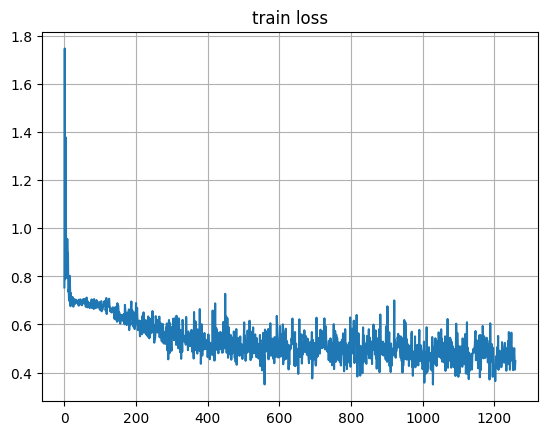

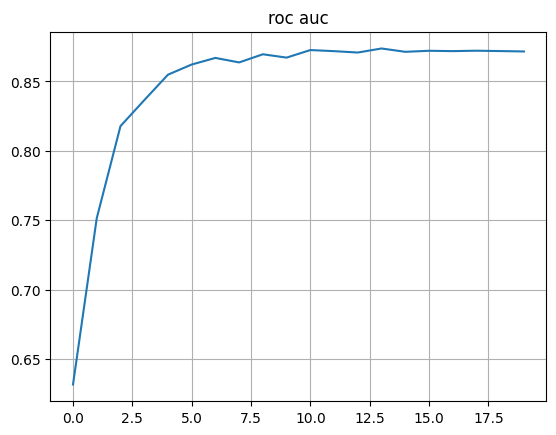

auc:  0.87156
epoch:  19


In [41]:
# TRAINING LOOP
for epoch in range(20):
    for emb, y in dataloader:
        mlp.train()

        predict = mlp(emb)
        loss = nn.BCELoss()(predict,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss)

    with torch.no_grad():
        correct = 0
        preds = []
        targets = []
        for emb, y in zip(embs_val_aggr,target_val):
            mlp.eval()
            predict = mlp(emb[None,...])
            preds.append(float(predict))
            targets.append(int(y.item()))
        auc = roc_auc_score(targets,preds)
        roc_auc.append(auc)

    clear_output(wait=True)
    plt.title("train loss")
    plt.plot([i.cpu().detach().numpy() for i in losses])
    plt.grid()
    plt.show()
    plt.title("roc auc")
    plt.plot(roc_auc)
    plt.grid()
    plt.show()
    print("auc: ",roc_auc[-1])
    print("epoch: ",epoch)

## 3. Tests

In [42]:
datasets = {
    "en-en-test": [dev_enen_x, dev_enen_y],
    "ru-ru-test": [test_ruru_x, test_ruru_y],
    "en-ru-test": [test_enru_x, test_enru_y],
    "ar-ar-test": [test_arar_x, test_arar_y],
    "fr-fr-test": [test_frfr_x, test_frfr_y],
    "zh-zh-test": [test_zhzh_x, test_zhzh_y],
    "en-fr-test": [test_enfr_x, test_enfr_y],
    "en-ar-test": [test_enar_x, test_enar_y],
    "en-zh-test": [test_enzh_x, test_enzh_y],
}

In [43]:
results = []
for ds in tqdm(datasets, desc="Processing Datasets"):
    
    print(f'Проверка результатов для датасета {ds}')
    embs_test, target_test = extract_embs(*datasets[ds]) 
    embs_test_aggr = []
    for emb1, emb2 in embs_test:
        embs_test_aggr.append(aggregate(emb1, emb2))
    
        
    with torch.no_grad():
        correct = 0
        preds = []
        targets = []
        for emb, y in zip(embs_test_aggr, target_test):
            mlp.eval()
            predict = mlp(emb)
            preds.append(float(predict.item()))
            targets.append(int(y.item()))
            
        auc = roc_auc_score(targets, preds)
        f1 = f1_score(targets, [1 if p > 0.5 else 0 for p in preds])
        precision = precision_score(targets, [1 if p > 0.5 else 0 for p in preds])
        recall = recall_score(targets, [1 if p > 0.5 else 0 for p in preds])
        results.append({
                "dataset": ds,
                "AUC": round(auc, 3),
                "F1": round(f1, 3),
                "Precision": round(precision, 3),
                "Recall": round(recall, 3)
            })

    

Processing Datasets:   0%|          | 0/9 [00:00<?, ?it/s]

Проверка результатов для датасета en-en-test


0it [00:00, ?it/s]

Проверка результатов для датасета ru-ru-test


0it [00:00, ?it/s]

Проверка результатов для датасета en-ru-test


0it [00:00, ?it/s]

Проверка результатов для датасета ar-ar-test


0it [00:00, ?it/s]

Проверка результатов для датасета fr-fr-test


0it [00:00, ?it/s]

Проверка результатов для датасета zh-zh-test


0it [00:00, ?it/s]

Проверка результатов для датасета en-fr-test


0it [00:00, ?it/s]

Проверка результатов для датасета en-ar-test


0it [00:00, ?it/s]

Проверка результатов для датасета en-zh-test


0it [00:00, ?it/s]

In [44]:
results_df = pd.DataFrame(results)
results_df

,dataset,AUC,F1,Precision,Recall
0,en-en-test,0.872,0.663,0.898,0.526
1,ru-ru-test,0.802,0.536,0.804,0.402
2,en-ru-test,0.641,0.054,0.778,0.028
3,ar-ar-test,0.763,0.580,0.790,0.458
4,fr-fr-test,0.799,0.579,0.787,0.458
5,zh-zh-test,0.766,0.004,1.000,0.002
6,en-fr-test,0.733,0.350,0.893,0.218
7,en-ar-test,0.606,0.035,0.900,0.018
8,en-zh-test,0.764,0.008,1.000,0.004


================================================================================================

- Модель хорошо работает на монолингвальных наборах (en-en, ru-ru, fr-fr)
- Кросс-лингвальные наборы значительно сложнее для модели:
  - Особенно для языков с сильными структурными различиями от английского (арабский, китайский).
  - Китайский язык вызывает серьёзные проблемы, даже в монолингвальном контексте (zh-zh), вероятно, из-за сложности и недостаточной проработки эмбеддингов в мультиязычной модели.